In [18]:
## notebook to generate the figures for the paper
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib, numbers
import scipy.optimize as opt
import scipy.signal as sig
from matplotlib.backends.backend_pdf import PdfPages
from scipy.ndimage import gaussian_filter1d


First the figure for the charge changes over time

In [27]:
file_label = "20231009"
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
data_dir = os.path.join(code_path, "data", file_label)
charge_data = np.load(data_dir+"/charge_data_%s.npz"%file_label)
for k in charge_data.keys():
    exec("%s = charge_data['%s']"%(k,k))

In [33]:
## fit half-life
def lfun(t, N0, t12, tot_time=tot_livetime, use_norm=True, dead_period_edges=all_bad_periods):
    tint = np.linspace(0, tot_time, 1000)
    norm = np.trapz(0.5**(tint/t12), tint)
    if(use_norm):
        val = 1/norm * 0.5**(t/t12)
    else:
        val = N0 * 0.5**(t/t12)
    bad_pts = np.zeros_like(t)
    for dp in dead_period_edges:
        inrange = ((t > dp[0]) & (t < dp[1]))
        bad_pts = np.logical_or(bad_pts, inrange)
    val[bad_pts] = 0
    return val

def nll(t, N0, t12, tot_time=tot_livetime):
    N = len(t)
    mu = N0*(1 - 0.5**(tot_time/t12))
    poiss = N*np.log(mu) - mu
    return -np.sum(np.log(lfun(t, 1, t12))) - poiss

## time of decays/half life
decay_times = good_change_list[:,0] #time_hours[1:][changes]
#big_decay_times = time_hours[1:][big_changes]

## likelihood fit
N0_vec = np.linspace(0, 150, 210)
t12_vec = np.linspace(0.5, 25, 200)
nll_mat_all = np.zeros((len(N0_vec), len(t12_vec)))
#nll_mat_big = np.zeros((len(N0_vec), len(t12_vec)))

for i,N0 in enumerate(N0_vec):
    for j,t12 in enumerate(t12_vec):
        nll_mat_all[i,j] = nll(decay_times, N0, t12)
        #nll_mat_big[i,j] = nll(big_decay_times, N0, t12)

nll_mat_all -= np.min(nll_mat_all)
#nll_mat_big -= np.min(nll_mat_big)

t12_true = 10.6 ## https://www.nndc.bnl.gov/nudat3/DecayRadiationServlet?nuc=212Pb&unc=NDS

nlls = [nll_mat_all,] # nll_mat_big]
labs = ["Fit to all reconstructed decays", "Fit to decays $>6$ $e$"]

params_from_profile = []
for j in range(1):
    
    N0_mesh, t12_mesh = np.meshgrid(N0_vec, t12_vec)
    profile = np.zeros_like(t12_vec)
    profile_nll = np.zeros_like(t12_vec)
    for k in range(len(t12_vec)):
        profile[k] = N0_vec[np.argmin(nlls[j][:,k])]
        profile_nll[k] = 2*np.min(nlls[j][:,k])

    cup = np.where((profile_nll <= 1) & (np.roll(profile_nll,-1) > 1))[0]
    clo = np.where((profile_nll <= 1) & (np.roll(profile_nll,1) > 1))[0]
    cv, uv, lv = t12_vec[np.argmin(profile_nll)], t12_vec[cup], t12_vec[clo]
    min_loc = np.argmin(nlls[j].T)
    bpN0, bpt12 = np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc]
    bpN0_lo, bpt12_lo = profile[clo], t12_vec[clo]
    bpN0_hi, bpt12_hi = profile[cup], t12_vec[cup]
    params_from_profile.append([bpN0, bpt12, bpN0_lo, bpt12_lo, bpN0_hi, bpt12_hi])

nbins = int(tot_livetime/3) + 2

decay_times_list = [decay_times,] # big_decay_times]

for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,int(time_hours[-1])))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_56143/2486507262.py:19: RuntimeWarning: divide by zero encountered in log
  poiss = N*np.log(mu) - mu


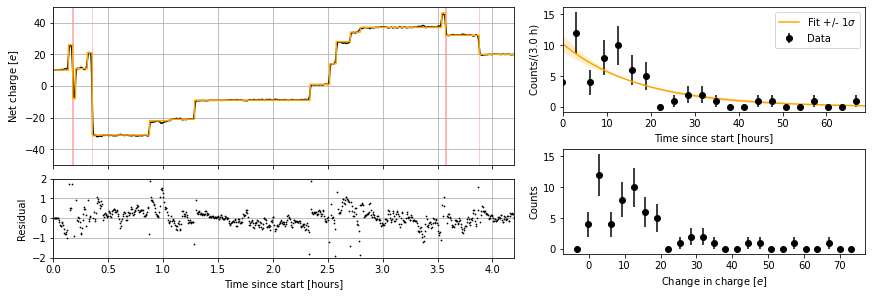

In [50]:
importlib.reload(bu)
recal = 1
init_charge = 10
fig = plt.figure(layout='constrained', figsize=(12, 4))
subfigs = fig.subfigures(1, 2, wspace=0.02, width_ratios=[1.5,1])
n_resamp = 3

axsLeft = subfigs[0].subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0})
#plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
t12 = 10.6
xv1, xv2 = 0, 4.2 #time_vals[-1]
time_vals = time_hours[1:]
diff_vec = np.gradient(corr_vec[1:,corr_idx]/cal_fac)
b, a = sig.butter(3, 0.000101, btype='high')
diff_vec = sig.filtfilt(b, a, diff_vec)
filt_vec = np.cumsum(diff_vec) + init_charge
filt_vec = gaussian_filter1d(filt_vec,n_resamp)
axsLeft[0].plot(time_vals, filt_vec, 'k-', label="Correlation")
axsLeft[0].plot(time_vals, running_charge, '-', color='orange', label="Recon. charge")
plt.sca(axsLeft[0])
plt.grid(True)
bu.fill_dps(dead_period_edges)
bu.fill_dps(lamp_period_edges, 'black', lab="UV lamp")
bu.fill_dps(filament_period_edges, 'red', lab="Filament")

plt.ylabel("Net charge [$e$]")
#plt.legend(loc="lower right")
plt.ylim(-50,50)
#plt.gca().set_xscale('log')
plt.xlim(xv1, xv2)

plt.sca(axsLeft[1])
resid = running_charge-filt_vec
axsLeft[1].plot(time_vals[::n_resamp], resid[::n_resamp], 'k.', ms=1.5)
plt.grid(True)
plt.xlim(xv1, xv2)
plt.ylabel("Residual")
plt.ylim(-2,2)
plt.gca().set_yticks([-2,-1,0,1,2])
plt.xlabel("Time since start [hours]")

axsMid = subfigs[1].subplots(2, 1)
plt.sca(axsMid[0])
#plt.subplot(1,2,j+1)
plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
curr_bp = params_from_profile[j]
xx = np.linspace(0,time_hours[-1],1000)
yy = np.log(2)*bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
ylo = np.log(2)*bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
yhi = np.log(2)*bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])

plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
#plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
#fill_dps()
plt.xlabel("Time since start [hours]")
plt.ylabel("Counts/(%.1f h)"%(bin_length))
plt.xlim(0,time_hours[-1])

plt.legend()

#axsRight = subfigs[2].subplots(1, 1)
plt.sca(axsMid[1])
ymin, ymax = -5, 1.1*np.max(good_change_list[:,1])
hh, be = np.histogram(good_change_list[:,1], bins=25, range=(ymin,ymax))
bc = be[:-1] + np.diff(be)/2

plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.xlabel("Change in charge [$e$]")
plt.ylabel("Counts")

plt.savefig("charge_fig_paper.pdf")

plt.show()